<a href="https://colab.research.google.com/github/takzen/pytorch-black-belt/blob/main/notebooks/46_PyTorch_Hooks_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --------------------------------------------------------------
# ☁️ COLAB SETUP (Automatyczna instalacja środowiska)
# --------------------------------------------------------------
import sys
import os

# Sprawdzamy, czy jesteśmy w Google Colab
if 'google.colab' in sys.modules:
    print('☁️ Wykryto środowisko Google Colab. Konfiguruję...')

    # 1. Pobieramy plik requirements.txt bezpośrednio z repozytorium
    !wget -q https://raw.githubusercontent.com/takzen/ai-engineering-handbook/main/requirements.txt -O requirements.txt

    # 2. Instalujemy biblioteki
    print('⏳ Instaluję zależności (to może chwilę potrwać)...')
    !pip install -q -r requirements.txt

    print('✅ Gotowe! Środowisko jest zgodne z repozytorium.')
else:
    print('💻 Wykryto środowisko lokalne. Zakładam, że masz już uv/venv.')


# 🥋 Lekcja 46: Grad-CAM od zera (Wizualizacja z Hookami)

Sieci CNN to nie czarne skrzynki. Możemy zajrzeć do środka.
Aby zrozumieć decyzję sieci, musimy połączyć dwie informacje:
1.  **Co sieć widzi?** (Aktywacje z ostatniej warstwy Conv).
2.  **Co jest dla niej ważne?** (Gradienty wchodzące do tej warstwy).

Algorytm Grad-CAM:
$$ Heatmap = ReLU(\sum_k \alpha_k A^k) $$
Gdzie:
*   $A^k$ to k-ta mapa cech (np. "wykrywacz uszu").
*   $\alpha_k$ to waga ważności (średni gradient dla tej mapy).

Użyjemy modelu **ResNet50** (wytrenowanego na ImageNet) i "włamiemy się" do jego ostatniej warstwy.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Pobieramy wytrenowany model
model = models.resnet50(weights='IMAGENET1K_V1').to(DEVICE)
model.eval() # Tryb ewaluacji (wyłącza Dropout)

print("ResNet50 gotowy.")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\takze/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:21<00:00, 4.86MB/s]


ResNet50 gotowy.


## Rejestracja Haków (Szpiegów)

Musimy znaleźć ostatnią warstwę konwolucyjną w ResNet.
W ResNet50 nazywa się ona `layer4[2].conv3` (lub po prostu ostatni blok `layer4`).

Zdefiniujemy dwie zmienne globalne (lub klasę), do których Hooki będą zrzucać dane.

In [2]:
# Magazyn na dane ze środka sieci
activations = None
gradients = None

# Funkcja dla Forward Hook (zapisuje mapy cech)
def forward_hook_fn(module, input, output):
    global activations
    activations = output.detach() # Odpinamy od grafu

# Funkcja dla Backward Hook (zapisuje gradienty)
def backward_hook_fn(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0].detach()

# Znajdujemy ostatnią warstwę (w ResNet to 'layer4')
target_layer = model.layer4[-1]

# Rejestrujemy szpiegów
handle_f = target_layer.register_forward_hook(forward_hook_fn)
handle_b = target_layer.register_full_backward_hook(backward_hook_fn)

print(f"Haki założone na: {target_layer}")

Haki założone na: Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)


## Pobranie Obrazka i Forward Pass

Pobierzemy zdjęcie (np. Słonia) i przepuścimy przez sieć.
Nasz `forward_hook` automatycznie przechwyci mapy cech.

In [9]:
# Pobieramy zdjęcie
url = "https://upload.wikimedia.org/wikipedia/commons/3/37/African_Bush_Elephant.jpg"
response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
img_pil = Image.open(BytesIO(response.content))

# Preprocessing dla ResNet
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(img_pil).unsqueeze(0).to(DEVICE)
input_tensor.requires_grad = True # Ważne! Chcemy, żeby gradient płynął

# --- FORWARD PASS ---
output = model(input_tensor)

# Wynik klasyfikacji
pred_idx = output.argmax(dim=1).item()
print(f"Sieć myśli, że to klasa ID: {pred_idx}")
# (386 to African Elephant w ImageNet)

Sieć myśli, że to klasa ID: 386


## Backward Pass (Liczenie Ważności)

Teraz musimy powiedzieć sieci: **"Wyjaśnij mi, dlaczego wybrałaś Słonia (klasa 386)?"**.

Robimy to, zerując gradienty dla wszystkich innych klas i zostawiając 1.0 tylko dla klasy Słonia.
Uruchamiamy `backward()`. Nasz `backward_hook` przechwyci gradienty w ostatniej warstwie.

In [10]:
# Zerujemy gradienty modelu
model.zero_grad()

# Tworzymy wektor celu (One-Hot dla klasy Słonia)
one_hot_output = torch.zeros_like(output)
one_hot_output[0, pred_idx] = 1.0

# --- BACKWARD PASS ---
output.backward(gradient=one_hot_output)

# Sprawdźmy co złapali szpiedzy
print(f"Kształt Aktywacji (Co widzi): {activations.shape}") # [1, 2048, 7, 7]
print(f"Kształt Gradientów (Co ważne): {gradients.shape}")   # [1, 2048, 7, 7]

Kształt Aktywacji (Co widzi): torch.Size([1, 2048, 7, 7])
Kształt Gradientów (Co ważne): torch.Size([1, 2048, 7, 7])


## Matematyka Grad-CAM (Łączenie)

Mamy:
1.  **Aktywacje ($A$):** 2048 małych obrazków 7x7.
2.  **Gradienty ($G$):** 2048 małych obrazków 7x7 (mówiących o ważności).

Algorytm:
1.  Obliczamy średnią wagę dla każdego z 2048 kanałów (Global Average Pooling na gradientach). To nam mówi: *"Kanał nr 55 (np. tekstura trąby) jest bardzo ważny dla decyzji 'Słoń'"*.
2.  Mnożymy mapy aktywacji przez te wagi.
3.  Sumujemy wszystko w jedną mapę 7x7.
4.  Nakładamy `ReLU` (interesują nas tylko cechy, które *pozytywnie* wpływają na decyzję).

In [11]:
# 1. Global Average Pooling na gradientach (Wagi alpha)
# [1, 2048, 7, 7] -> [1, 2048, 1, 1]
weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

# 2. Mnożenie map cech przez wagi
# [1, 2048, 7, 7] * [1, 2048, 1, 1] -> [1, 2048, 7, 7]
weighted_activations = activations * weights

# 3. Suma po kanałach (Spłaszczanie do jednej mapy ciepła)
# [1, 2048, 7, 7] -> [1, 7, 7]
heatmap = torch.sum(weighted_activations, dim=1).squeeze()

# 4. ReLU (Odrzucamy ujemne wpływy)
heatmap = F.relu(heatmap)

# 5. Normalizacja (do zakresu 0-1 dla ładnego wyświetlania)
heatmap /= torch.max(heatmap)

print("Mapa ciepła wygenerowana.")

Mapa ciepła wygenerowana.


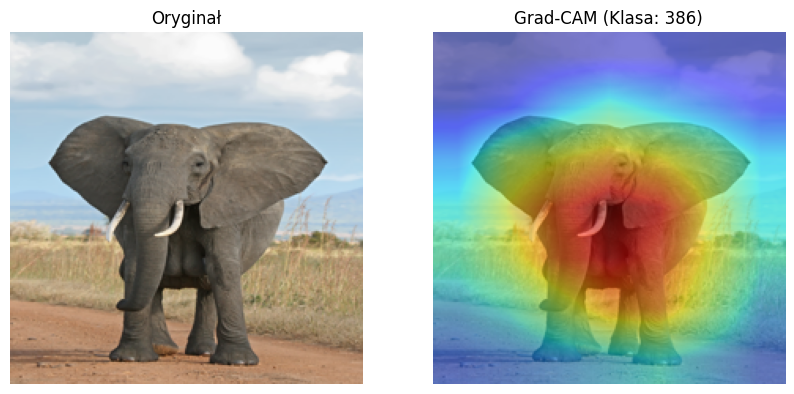

In [6]:
# WIZUALIZACJA KOŃCOWA

# Skalujemy heatmapę 7x7 do rozmiaru oryginalnego obrazka (224x224)
heatmap_resized = F.interpolate(
    heatmap.unsqueeze(0).unsqueeze(0), 
    size=(224, 224), 
    mode='bilinear'
).squeeze().detach().cpu().numpy()

# Przygotowanie oryginału do wyświetlenia
img_display = np.array(img_pil.resize((224, 224)))

# Wykres
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_display)
plt.title("Oryginał")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_display)
plt.imshow(heatmap_resized, cmap='jet', alpha=0.5) # Nakładamy mapę ciepła
plt.title(f"Grad-CAM (Klasa: {pred_idx})")
plt.axis('off')

plt.show()

# Sprzątanie hooków
handle_f.remove()
handle_b.remove()

## 🥋 Black Belt Summary

Spójrz na wynik. Czerwone plamy powinny pokrywać się z **głową i trąbą słonia**.
To dowód, że sieć nie patrzy na trawę ani niebo. Patrzy na kluczowe cechy obiektu.

**Zastosowanie:**
1.  **Debugging:** Jeśli sieć myli Wilka z Psem Husky, Grad-CAM może pokazać, że sieć patrzy na... śnieg w tle (bo wilki są często na śniegu). To znany błąd "Clever Hans".
2.  **Medycyna:** Lekarz musi wiedzieć, dlaczego AI twierdzi, że na rentgenie jest guz. Grad-CAM zaznacza podejrzany obszar.